In [728]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import os
import seaborn as sns
import re
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [729]:
df = pd.read_csv("/home/nsl53/Desktop/NSL_Training/MachineLearning/dataset/WA_Fn-UseC_-Telco-Customer-Churn.csv")
print(df.customerID.nunique())

7043


In [730]:
df.head()

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month              Yes   
1          No          No              No        One year               No   
2          No          No              No  Month-to-month              Yes   
3         Yes          No              No        One year               No   
4          No          No              No  Month-to-month              Yes   

               PaymentMethod MonthlyCharges  TotalCharges Churn  
0           Electronic check          29.85         29.85    No  
1               Mailed check          56.95        1889.5    No  
2               Mailed check          53.85        108.15   Yes  
3  Bank transfer (automatic)          42.30       1840.75    No  
4           Electronic check          70.70        151.65   Yes  

[5 rows x 21 columns]

##### The customerID column seems to be some type of primary key for relational mapping and is of no use in the dataset, so lets drop it 

In [731]:
df.drop(axis=1,labels='customerID',inplace=True)


In [732]:
df.nunique()

gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64

In [733]:
bincols=list(df.nunique()[df.nunique()==2].index)
numcols=list(df.nunique()[df.nunique()>10].index)
catcols=df.columns[~df.columns.isin(numcols+bincols)]
print(f"From here we can see that we have:\n  {len(numcols)} numerical columns,\n  {len(bincols)} binary columns,\n  {len(catcols)} categorical columns.")

From here we can see that we have:
  3 numerical columns,
  7 binary columns,
  10 categorical columns.


In [734]:
print("Dtypes in numcols:")
print({i:df[i].dtype for i in numcols})
print("Dtypes in bincols:")
print({i:df[i].dtype for i in bincols})
print("Dtypes in catcols:")
print({i:df[i].dtype for i in catcols})

Dtypes in numcols:
{'tenure': dtype('int64'), 'MonthlyCharges': dtype('float64'), 'TotalCharges': dtype('O')}
Dtypes in bincols:
{'gender': dtype('O'), 'SeniorCitizen': dtype('int64'), 'Partner': dtype('O'), 'Dependents': dtype('O'), 'PhoneService': dtype('O'), 'PaperlessBilling': dtype('O'), 'Churn': dtype('O')}
Dtypes in catcols:
{'MultipleLines': dtype('O'), 'InternetService': dtype('O'), 'OnlineSecurity': dtype('O'), 'OnlineBackup': dtype('O'), 'DeviceProtection': dtype('O'), 'TechSupport': dtype('O'), 'StreamingTV': dtype('O'), 'StreamingMovies': dtype('O'), 'Contract': dtype('O'), 'PaymentMethod': dtype('O')}


##### As we can see that there seems to be discripency in one data type, specifically "TotalCharges", so we need to fix this. As for SeniorCitizens, binary data is often represented as integers (0,1).   

<AxesSubplot:>

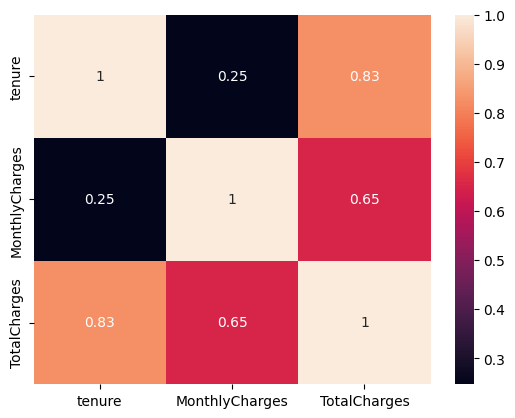

In [735]:
feature_corr=df[numcols][df.TotalCharges.str.match(r"\d+")]
feature_corr['TotalCharges']=feature_corr.TotalCharges.astype('float64')
sns.heatmap(feature_corr.corr(),annot=True)

In [736]:
df['tenure'][df['Churn']==0]

Series([], Name: tenure, dtype: int64)

##### As we can see there is high colinearity between TotalCharges and the other two columns, we can drop TotalCharges and make a new column that combines the other two columns

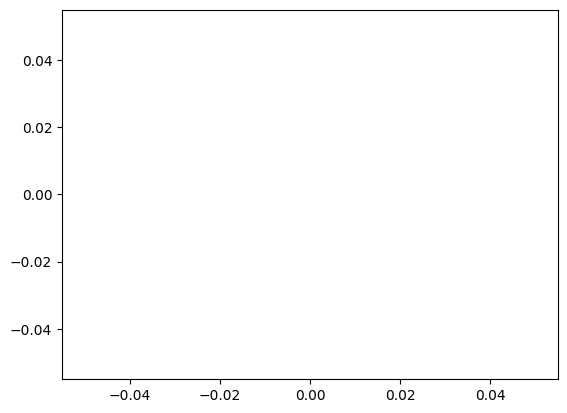

In [737]:
df=df.drop(axis=1,labels='TotalCharges')
df['numerical']=df.tenure*df.MonthlyCharges
plt.scatter(df['tenure'][df['Churn']==0],df['numerical'][df['Churn']==0],c='r')
plt.scatter(df['tenure'][df['Churn']==1],df['numerical'][df['Churn']==1],c='g')
df=df.drop(axis=1,labels=['tenure','MonthlyCharges'])

<AxesSubplot:ylabel='Density'>

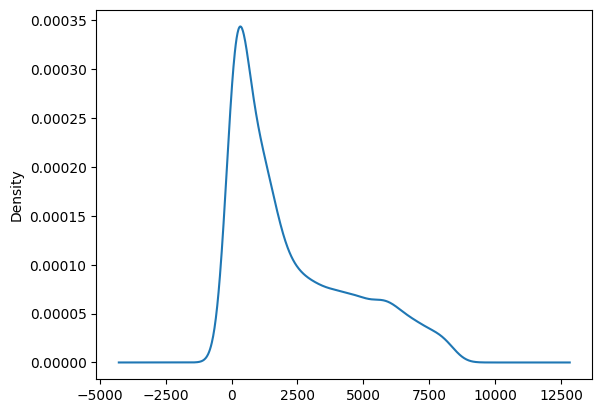

In [738]:
df["numerical"].plot.kde()

##### As we can see that there is some skewness to our numerical column, lets see if we have any outliers

In [739]:
q_=df['numerical'].quantile([0.25,0.75]).to_list()
out_range=1.5*(q_[1]-q_[0])
print(f"Number of outliers in numerical: {df[~df['numerical'].between(*[q_[0]-out_range,q_[1]+out_range])].size}")
print("As we can see no presence of outliers, we shall use StandardScaler for better performance on outliers")


Number of outliers in numerical: 0
As we can see no presence of outliers, we shall use StandardScaler for better performance on outliers


In [740]:
sscale=StandardScaler()
df['numerical']=sscale.fit_transform(df['numerical'].to_numpy().reshape(-1,1))

##### Now lets move unto our other sets of datatypes, specifically our Binary Columns. Since most of our binary data is either "Yes" or "No" except for gender, lets turn them into binary format.

In [741]:
df['SeniorCitizen']=df['SeniorCitizen'].astype('O')

In [742]:
for i in bincols:
    df[i]=df[i].apply(lambda x: 1  if x=='Yes' or x=='Male' else 0)
df

gender  SeniorCitizen  Partner  Dependents  PhoneService  \
0          0              0        1           0             0   
1          1              0        0           0             1   
2          1              0        0           0             1   
3          1              0        0           0             0   
4          0              0        0           0             1   
...      ...            ...      ...         ...           ...   
7038       1              0        1           1             1   
7039       0              0        1           1             1   
7040       0              0        1           1             0   
7041       1              0        1           0             1   
7042       1              0        0           0             1   

         MultipleLines InternetService OnlineSecurity OnlineBackup  \
0     No phone service             DSL             No          Yes   
1                   No             DSL            Yes           No   
2                   No             DSL            Yes          Yes   
3     No phone service             DSL            Yes           No   
4                   No     Fiber optic             No           No   
...                ...             ...            ...          ...   
7038               Yes             DSL            Yes           No   
7039               Yes     Fiber optic             No          Yes   
7040  No phone service             DSL            Yes           No   
7041               Yes     Fiber optic             No           No   
7042                No     Fiber optic            Yes           No   

     DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0                  No          No          No              No  Month-to-month   
1                 Yes          No          No              No        One year   
2                  No          No          No              No  Month-to-month   
3                 Yes         Yes          No              No        One year   
4                  No          No          No              No  Month-to-month   
...               ...         ...         ...             ...             ...   
7038              Yes         Yes         Yes             Yes        One year   
7039              Yes          No         Yes             Yes        One year   
7040               No          No          No              No  Month-to-month   
7041               No          No          No              No  Month-to-month   
7042              Yes         Yes         Yes             Yes        Two year   

      PaperlessBilling              PaymentMethod  Churn  numerical  
0                    1           Electronic check      0  -0.993448  
1                    0               Mailed check      0  -0.151588  
2                    1               Mailed check      1  -0.959071  
3                    0  Bank transfer (automatic)      0  -0.166072  
4                    1           Electronic check      1  -0.944189  
...                ...                        ...    ...        ...  
7038                 1               Mailed check      0  -0.107915  
7039                 1    Credit card (automatic)      0   2.274525  
7040                 1           Electronic check      0  -0.862849  
7041                 1               Mailed check      1  -0.875214  
7042                 1  Bank transfer (automatic)      0   2.072500  

[7043 rows x 18 columns]

In [743]:
for i in catcols:
    print(i)
    print(df[i].unique())

MultipleLines
['No phone service' 'No' 'Yes']
InternetService
['DSL' 'Fiber optic' 'No']
OnlineSecurity
['No' 'Yes' 'No internet service']
OnlineBackup
['Yes' 'No' 'No internet service']
DeviceProtection
['No' 'Yes' 'No internet service']
TechSupport
['No' 'Yes' 'No internet service']
StreamingTV
['No' 'Yes' 'No internet service']
StreamingMovies
['No' 'Yes' 'No internet service']
Contract
['Month-to-month' 'One year' 'Two year']
PaymentMethod
['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']


##### From here we can see that all columns with both 'Yes' and 'No' as unique values can be represented as ordinal data, also, 'Contract' and 'InternetService' follows an ordinal structure.Now, lets keep two datasets, one with ordinal representation of available ordinal features among all the categorical features and one with one hot encoding of all the categorical features

In [744]:
catcols_=catcols
ordcols=[i for i in catcols if "Payment" not in i]
print(ordcols)
catcols=['PaymentMethod']

['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract']


In [745]:
df.head(20)

gender  SeniorCitizen  Partner  Dependents  PhoneService  \
0        0              0        1           0             0   
1        1              0        0           0             1   
2        1              0        0           0             1   
3        1              0        0           0             0   
4        0              0        0           0             1   
5        0              0        0           0             1   
6        1              0        0           1             1   
7        0              0        0           0             0   
8        0              0        1           0             1   
9        1              0        0           1             1   
10       1              0        1           1             1   
11       1              0        0           0             1   
12       1              0        1           0             1   
13       1              0        0           0             1   
14       1              0        0           0             1   
15       0              0        1           1             1   
16       0              0        0           0             1   
17       1              0        0           1             1   
18       0              0        1           1             1   
19       0              0        0           0             1   

       MultipleLines InternetService       OnlineSecurity  \
0   No phone service             DSL                   No   
1                 No             DSL                  Yes   
2                 No             DSL                  Yes   
3   No phone service             DSL                  Yes   
4                 No     Fiber optic                   No   
5                Yes     Fiber optic                   No   
6                Yes     Fiber optic                   No   
7   No phone service             DSL                  Yes   
8                Yes     Fiber optic                   No   
9                 No             DSL                  Yes   
10                No             DSL                  Yes   
11                No              No  No internet service   
12               Yes     Fiber optic                   No   
13               Yes     Fiber optic                   No   
14                No     Fiber optic                  Yes   
15               Yes     Fiber optic                  Yes   
16                No              No  No internet service   
17               Yes     Fiber optic                  Yes   
18                No             DSL                   No   
19                No     Fiber optic                   No   

           OnlineBackup     DeviceProtection          TechSupport  \
0                   Yes                   No                   No   
1                    No                  Yes                   No   
2                   Yes                   No                   No   
3                    No                  Yes                  Yes   
4                    No                   No                   No   
5                    No                  Yes                   No   
6                   Yes                   No                   No   
7                    No                   No                   No   
8                    No                  Yes                  Yes   
9                   Yes                   No                   No   
10                   No                   No                   No   
11  No internet service  No internet service  No internet service   
12                   No                  Yes                   No   
13                  Yes                  Yes                   No   
14                   No                  Yes                  Yes   
15                  Yes                  Yes                  Yes   
16  No internet service  No internet service  No internet service   
17                   No                  Yes                   No   
18                   No                  Yes                  Yes 

#### Method 1: Ordinal encoding for ordinal feature subset within categorical feature set

In [746]:
def to_ord(x):
    if (x=='Yes') | (x=='Two year') | (x=='Fiber optic'):
        return 2
    elif (x=='No') | (x=='One year') | (x=='DSL'):
        return 1
    else:
        return 0
df_=df.__deepcopy__()
for i in ordcols:
    df[i]=df[i].apply(lambda x:to_ord(x))

In [747]:
mnmx_scale=MinMaxScaler()
df[ordcols]=mnmx_scale.fit_transform(df[ordcols].to_numpy().reshape(-1,len(ordcols)))
cathot=pd.get_dummies(df[catcols])
df.drop(labels=catcols,axis=1,inplace=True)
df=pd.concat([df,cathot],axis=1)
y=df['Churn'].to_numpy().reshape(-1,1)
x=df.drop(labels="Churn",axis=1).to_numpy()

In [748]:
train_x,test_x,train_y,test_y=train_test_split(x,y,test_size=0.3,random_state=123)
log_reg=LogisticRegression()

In [749]:
param_grid=[
    {'penalty':['l1','l2','elasticnet','none',],
    'C':np.logspace(-4.4,20),
    'solver':["lbfgs",'newton-cg','liblinear','sag','saga'],
    'max_iter':[100,500,1000,2500,5000]
    }
]

In [750]:
clf=GridSearchCV(log_reg,param_grid=param_grid,cv=4,verbose=True,n_jobs=1)

In [751]:
best_fit=clf.fit(x,y)

Fitting 4 folds for each of 5000 candidates, totalling 20000 fits


/home/nsl53/anaconda3/envs/eda_/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nsl53/anaconda3/envs/eda_/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nsl53/anaconda3/envs/eda_/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nsl53/anaconda3/envs/eda_/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when 

In [767]:
best_fit.score(x,y)

0.7996592361209712

In [758]:
l_reg.fit(x,y)

/home/nsl53/anaconda3/envs/eda_/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=0.12181879120101148, penalty='l1', solver='liblinear')

In [759]:
l_reg.score(x,y)

0.7996592361209712

#### Method 2: One Hot Encoding for whole Categorical Set

In [752]:

df_.drop(axis=1,labels='Churn',inplace=True)
dummy=df_[catcols_]
df_.drop(axis=1,labels=catcols_,inplace=True)
cat_df=pd.get_dummies(dummy)
df_=pd.concat([df_,cat_df],axis=1)
x_=df_.to_numpy()
y_=df_['Churn'].to_numpy().reshape(-1,1)

KeyError: 'Churn'

In [ ]:
train_x_,test_x_,train_y_,test_y_=train_test_split(x,y,test_size=0.3,random_state=123)